In [20]:
#!/usr/bin/python3

import os

log_dir = "../scripts/logs/1/32/worker/"
logs = os.listdir(log_dir)
print(logs)

COLOR_CODES = {
    "conn": "",
    "chunk_req": "",
    "chunk_resp": "",
    "salt_gen": "",
    "prev_salt_req": "",
    "prev_salt_resp": "",
    "salt_set": "",
    "enc": "",
    "cipher_write": "",
    "signal_done": ""
}

['chunk32', 'chunk28', 'chunk8', 'chunk5', 'chunk17', 'chunk3', 'chunk14', 'chunk21', 'chunk31', 'chunk23', 'chunk16', 'chunk4', 'chunk2', 'chunk27', 'chunk30', 'chunk25', 'chunk22', 'chunk13', 'chunk11', 'chunk26', 'chunk19', 'chunk6', 'chunk18', 'chunk24', 'chunk10', 'chunk29', 'chunk33', 'chunk15', 'chunk7', 'chunk20', 'chunk12', 'chunk9']


In [21]:
import numpy as np
from matplotlib import pyplot as plt

ITERATIONS = 100

def rm_outliers(iteration_log, mean, std, y_offset, ax):
    outliers = list(filter(lambda el: el[1] >= mean + 3*std or el[1] < mean - 3*std ,enumerate(iteration_log)))
    if len(outliers) == 0:
        return mean
    ax.scatter([el[0] for el in outliers], [el[1] for el in outliers], c='r', s=50)
    for outlier in outliers:
        iteration_log[outlier[0]] = mean
    
    p = ax.plot(range(0, len(iteration_log)), iteration_log)
    mean = np.mean(iteration_log)
    std = np.std(iteration_log)
    max_val = max(iteration_log)
    min_val = min(iteration_log)
    ax.hlines(mean, 0, ITERATIONS - 1, color=p[0].get_color())
    ax.text(.87, .80 - y_offset, 'Mean: {:.5f} \nSTD:   {:.5f} \nMax:   {:.5f} \nMin:    {:.5f}'.format(mean, std,max_val, min_val),  transform=ax.transAxes)
    return rm_outliers(iteration_log, mean, std, y_offset + .2, ax)


def get_mean(values, title = ""):
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    mean = np.mean(values)
    std = np.std(values)

    final_mean = rm_outliers(values, mean, std, .2, ax)
    print('final mean: ', final_mean)
    return final_mean

FS: 1   -   CS: 32
final mean:  11.7176
FS: 1   -   CS: 64
final mean:  12.0
FS: 1   -   CS: 128
final mean:  12.373899999999999
FS: 1   -   CS: 256
final mean:  12.8
FS: 1   -   CS: 512
final mean:  17.0938
--------------------------

FS: 2   -   CS: 32
final mean:  45.401693704724
FS: 2   -   CS: 64
final mean:  45.64
FS: 2   -   CS: 128
final mean:  47.146168977207886
FS: 2   -   CS: 256
final mean:  48.403400000000005
FS: 2   -   CS: 512
final mean:  50.393299999999996
--------------------------

FS: 3   -   CS: 32
final mean:  81.08567224988683
FS: 3   -   CS: 64
final mean:  81.37
FS: 3   -   CS: 128
final mean:  82.2111
FS: 3   -   CS: 256
final mean:  84.12
FS: 3   -   CS: 512
final mean:  84.96869999999998
--------------------------



<Figure size 2160x2160 with 0 Axes>

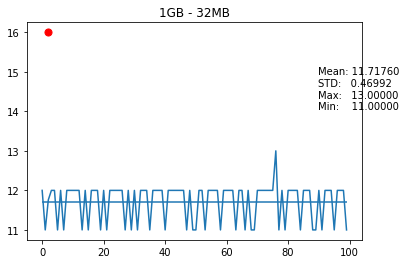

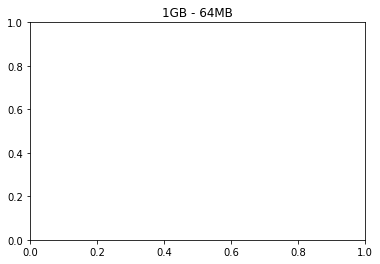

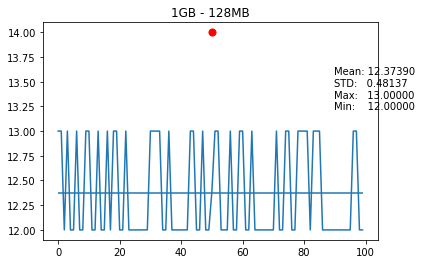

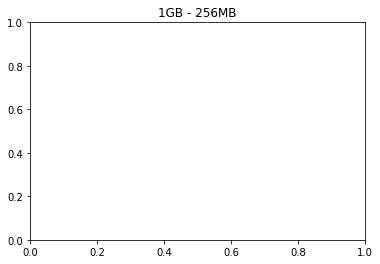

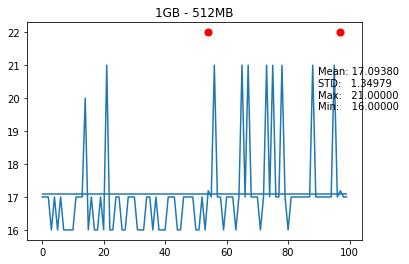

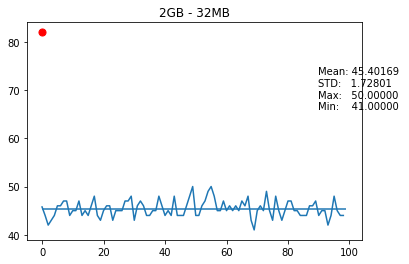

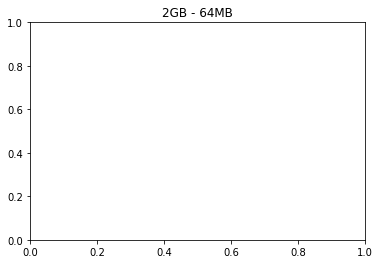

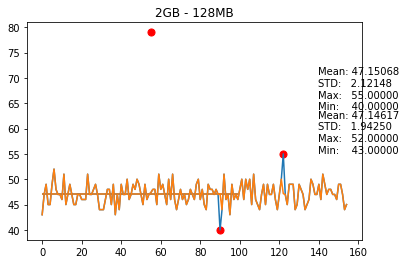

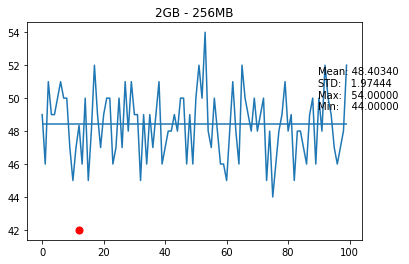

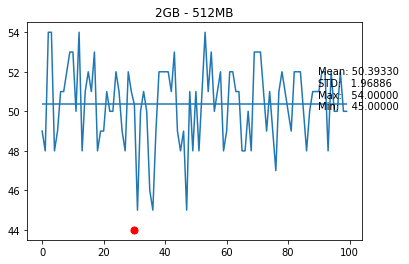

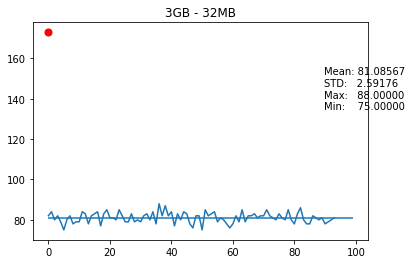

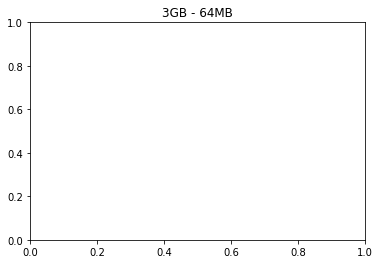

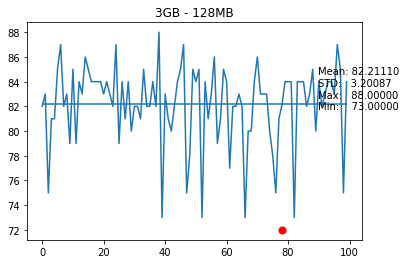

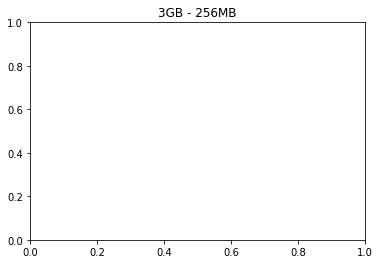

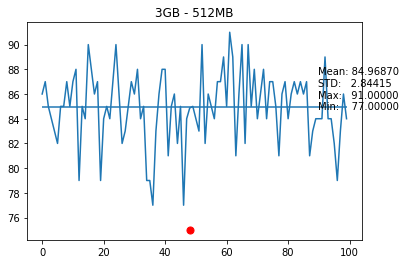

In [22]:
plt.figure(figsize=(30,30))
logs_dir = "/home/oussama/Workspace/research/dcbc/app/distributed/parallel/analysis/logs"
file_sizes = [1, 2, 3]
chunk_sizes = [32, 64, 128, 256, 512]


data = {}
for file_size in file_sizes:
    data[str(file_size)] = {}
    for chunk_size in chunk_sizes:
        data[str(file_size)][str(chunk_size)] = []

with open(logs_dir + "/master.log.2", 'r') as log_file:
    for line in log_file.readlines():
        split_data = line.strip().split(',')
        if split_data[1] in data and split_data[5] in data[split_data[1]]:
            data[split_data[1]][split_data[5]].append(float(split_data[2]))
        #df = pd.DataFrame( [x.split(',') for x in logs])

mean_costs = {}
for file_size in file_sizes:
    mean_costs[file_size] = {}
    for chunk_size in chunk_sizes:
        mean_costs[file_size][chunk_size] = -1

for file_size in file_sizes:
    for chunk_size in chunk_sizes:
        print(f"FS: {file_size}   -   CS: {chunk_size}")
        mean_costs[file_size][chunk_size] = get_mean(data[str(file_size)][str(chunk_size)], str(file_size) + "GB - " + str(chunk_size) + "MB")
    print("--------------------------\n")

[11.7176, 12.0, 12.373899999999999, 12.8, 17.0938]
[45.401693704724, 45.64, 47.146168977207886, 48.403400000000005, 50.393299999999996]
[81.08567224988683, 81.37, 82.2111, 84.12, 84.96869999999998]


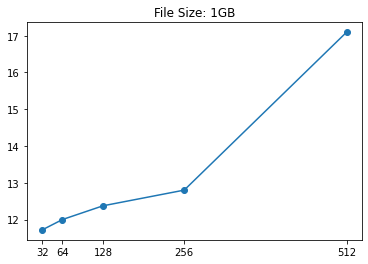

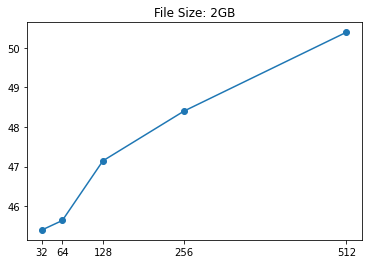

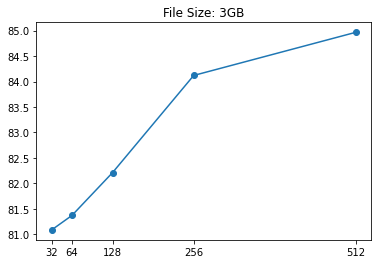

In [24]:
# chunk size effect

for file_size in file_sizes:
    fig, ax = plt.subplots(1, 1)
    ax.set_title("File Size: " + str(file_size) + "GB")
    ax.set_xticks(chunk_sizes)
    ax.plot(chunk_sizes, [mean_costs[file_size][cs] for cs in chunk_sizes], marker='o', linestyle='-')
    fig.savefig(f"{file_size}GB.png")
    print([mean_costs[file_size][cs] for cs in chunk_sizes])

[2.410049839557596, 5.600976309141803, 9.237386495528108, 45.88140916228582]
[0.52488415261742, 3.8423132049418918, 6.611441226836162, 10.994317365646253]
[0.3506510363963528, 1.3879489666742524, 3.742125662795394, 4.788796395677138]


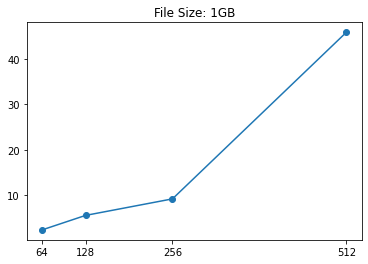

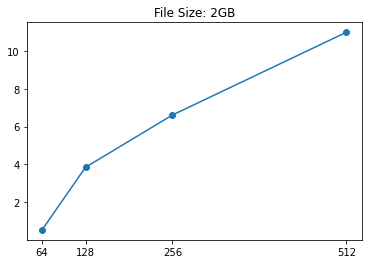

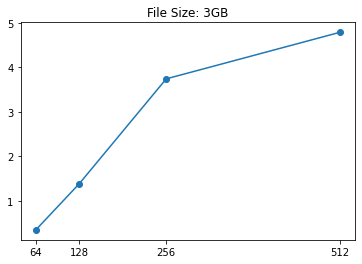

In [28]:
for file_size in file_sizes:
    fig, ax = plt.subplots(1, 1)
    ax.set_title("File Size: " + str(file_size) + "GB")
    ax.set_xticks(chunk_sizes[1:])
    ax.plot(chunk_sizes[1:],
            [((mean_costs[file_size][chunk_sizes[i]] - mean_costs[file_size][32])/mean_costs[file_size][32])*100 for i in range(1, len(chunk_sizes))],
            marker='o', linestyle='-')
    fig.savefig(f"{file_size}GB.png")
    print([((mean_costs[file_size][chunk_sizes[i]] - mean_costs[file_size][32])/mean_costs[file_size][32])*100 for i in range(1, len(chunk_sizes))])

In [21]:
#The sequential part

FS: 1   -   CS: 32
final mean:  21.132230179999997
--------------------------

FS: 2   -   CS: 32
final mean:  53.989305639526854
--------------------------

FS: 3   -   CS: 32
final mean:  137.90377166849464
--------------------------



<Figure size 2160x2160 with 0 Axes>

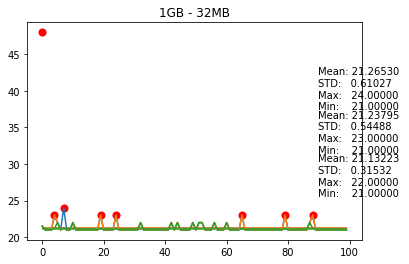

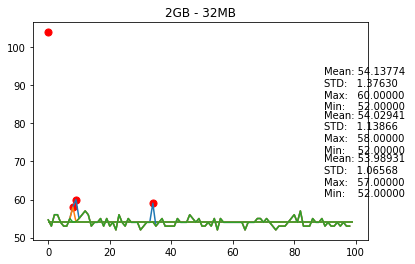

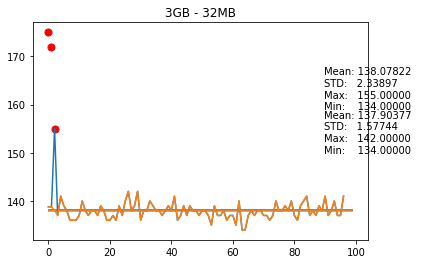

In [14]:
plt.figure(figsize=(30,30))
logs_dir = "/home/oussama/Workspace/research/dcbc/app/distributed/parallel/analysis/logs"
file_sizes = [1, 2, 3]
chunk_sizes = [32]


data = {}
for file_size in file_sizes:
    data[str(file_size)] = {}
    for chunk_size in chunk_sizes:
        data[str(file_size)][str(chunk_size)] = []

with open(logs_dir + "/seq.master.log", 'r') as log_file:
    for line in log_file.readlines():
        split_data = line.strip().split(',')
        if split_data[1] in data and split_data[5] in data[split_data[1]]:
            data[split_data[1]][split_data[5]].append(float(split_data[2]))
        #df = pd.DataFrame( [x.split(',') for x in logs])

seq_mean_costs = {}
for file_size in file_sizes:
    seq_mean_costs[file_size] = {}
    for chunk_size in chunk_sizes:
        seq_mean_costs[file_size][chunk_size] = -1

for file_size in file_sizes:
    for chunk_size in chunk_sizes:
        print(f"FS: {file_size}   -   CS: {chunk_size}")
        seq_mean_costs[file_size][chunk_size] = get_mean(data[str(file_size)][str(chunk_size)], str(file_size) + "GB - " + str(chunk_size) + "MB")
    print("--------------------------\n")

[21.132230179999997, 53.989305639526854, 137.90377166849464]


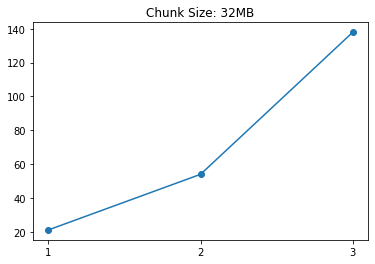

In [13]:

# file size costs

for chunk_size in chunk_sizes:
    fig, ax = plt.subplots(1, 1)
    ax.set_title("Chunk Size: " + str(chunk_size) + "MB")
    ax.set_xticks(file_sizes)
    ax.plot(file_sizes, [seq_mean_costs[file_size][chunk_size] for file_size in file_sizes], marker='o', linestyle='-')
    print([seq_mean_costs[file_size][chunk_size] for file_size in file_sizes])

In [24]:
#Compare DCBC To seq

[21.132230179999997, 53.989305639526854, 137.90377166849464]
[11.7176, 45.401693704724, 81.08567224988683]


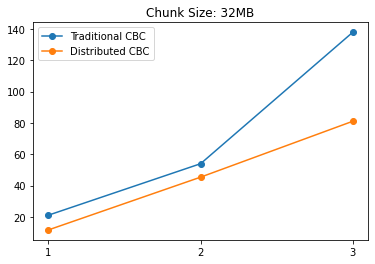

In [19]:


# file size costs

chunk_size = 32
fig, ax = plt.subplots(1, 1)
ax.set_title("Chunk Size: " + str(chunk_size) + "MB")
ax.set_xticks(file_sizes)
ax.plot(file_sizes, [seq_mean_costs[file_size][chunk_size] for file_size in file_sizes], marker='o', linestyle='-', label="Traditional CBC")
ax.plot(file_sizes, [mean_costs[file_size][chunk_size] for file_size in file_sizes], marker='o', linestyle='-', label="Distributed CBC")
print([seq_mean_costs[file_size][chunk_size] for file_size in file_sizes])
print([mean_costs[file_size][chunk_size] for file_size in file_sizes])
ax.legend()
fig.savefig("cbc_vs_dcbc.png")
